In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from nequix.data import *
from load_atoms import load_dataset
from ase.io import read, extxyz
import numpy as np
import matplotlib.pyplot as plt
import jax
import matplotlib.pyplot as plt
from nequix.model import Nequix

In [2]:
species = [1, 6, 7, 8, 16]
atomic_indices = atomic_numbers_to_indices(species)

In [8]:
ds = load_dataset('QM7', 'data')
for i in ds:
    i.set_cell(np.eye(3))
extxyz.write_extxyz('data/QM7.extxyz', ds)

Output()

In [9]:
basis = {1:1, 6:5, 7:5, 8:5, 16:9}
max(ds, key = lambda x: sum([basis[a] for a in x.get_atomic_numbers()]))

Atoms(symbols='C7H16', pbc=False, cell=[1.0, 1.0, 1.0])

In [10]:
7*5 + 16

51

In [14]:
graph_ds = Dataset('data/QM7.extxyz', atomic_indices)
dl = DataLoader(graph_ds, 23, 490, 15, 210, 64)

saving graphs: 100%|██████████| 7165/7165 [00:20<00:00, 353.73it/s]


In [15]:
a = next(iter(dl))
a

GraphsTuple(nodes={'forces': None, 'positions': array([[ 0.99826, -0.00246, -0.00436],
       [ 2.09021, -0.00243,  0.00414],
       [ 0.63379,  1.02686,  0.00414],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]], dtype=float32), 'species': array([1, 0, 0, ..., 0, 0, 0], dtype=int32)}, edges={'shifts': array([[ 0., -1., -1.],
       [ 0., -1., -1.],
       [ 0., -1., -1.],
       ...,
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)}, receivers=array([  0,   0,   0, ..., 640, 640, 640], dtype=int32), senders=array([  1,   2,   3, ..., 640, 640, 640], dtype=int32), globals=None, n_node=array([  5,   8,   6,   4,   9,   7,   9,   9,  11,   9,   7,   8,  10,
         6,  10,   7,  10,  12,  10,  11,  11,  13,   7,   5,  13,   9,
        12,  13,  11,  13,  11,  11,   9,  10,  10,  12,   8,  12,  12,
        10,  10,  12,  10,  10,   6,  10,   8,   9,  14,   9,   9,   9,


In [16]:
P = scf_density_matrix(ds[0], 'sto-3g')

converged SCF energy = -39.7265814231022


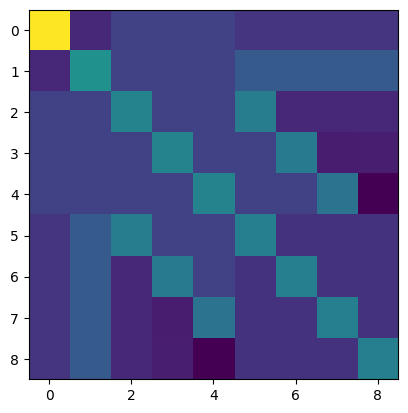

In [17]:
plt.imshow(P)

In [18]:
basis_irreps_e3nn('sto-3g')

['1x0e', '2x0e + 1x1o', '2x0e + 1x1o', '2x0e + 1x1o', '3x0e + 2x1o']

In [19]:
model = Nequix(jax.random.key(69), basis='sto-3g')

: 

In [21]:
batch = next(iter(dl))
P, mask_P, G_mask = model(batch)

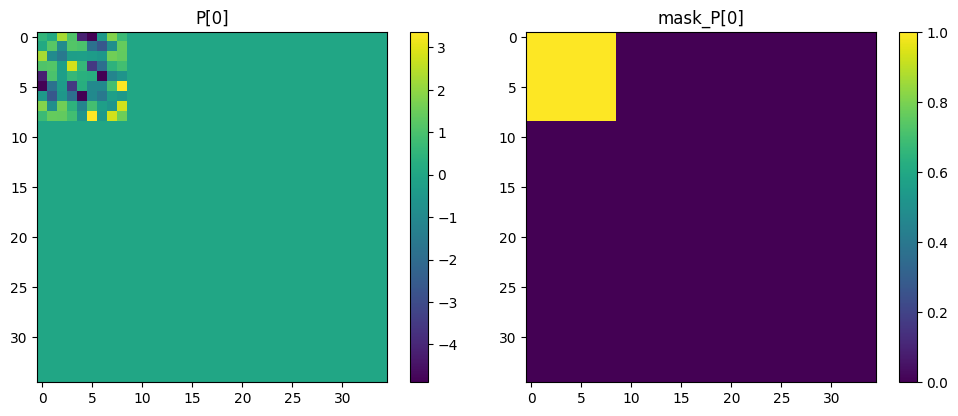

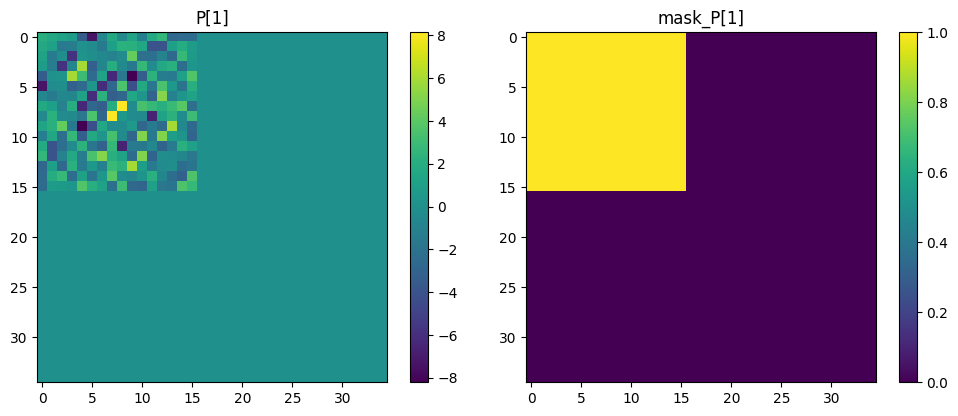

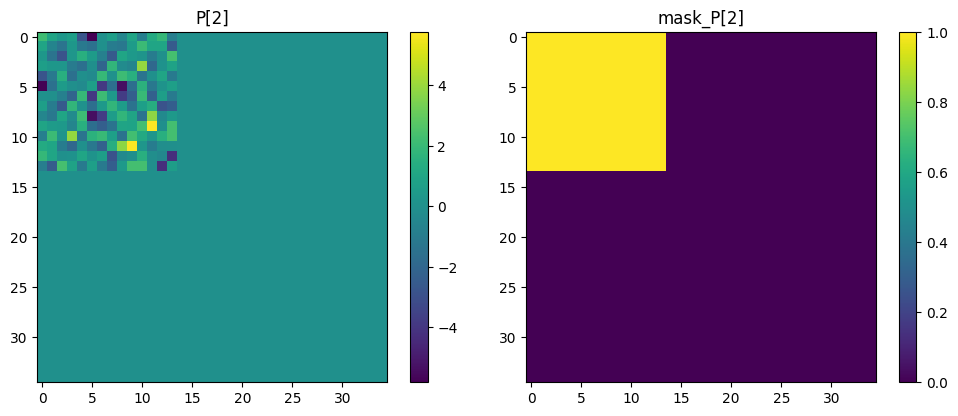

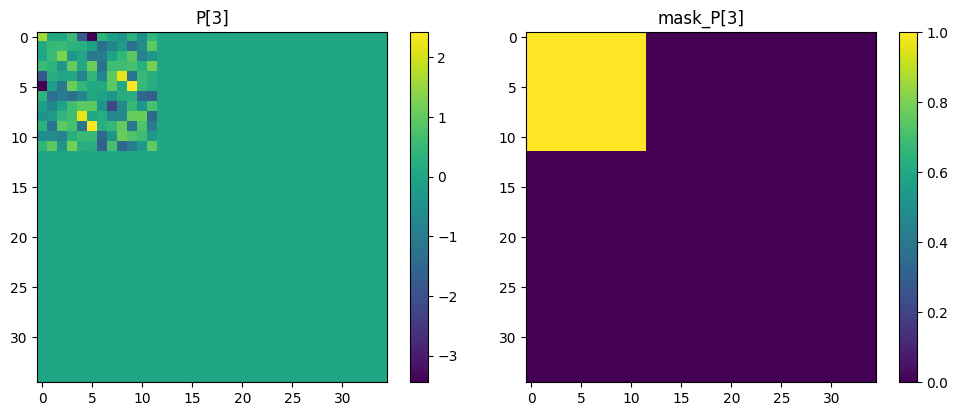

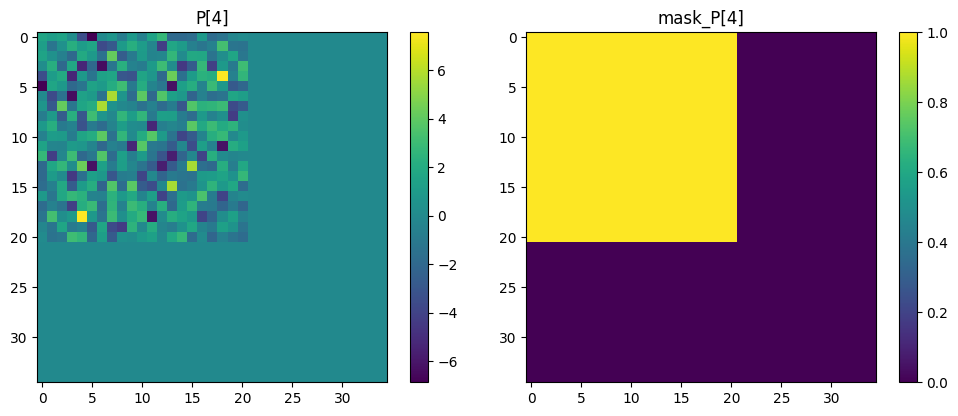

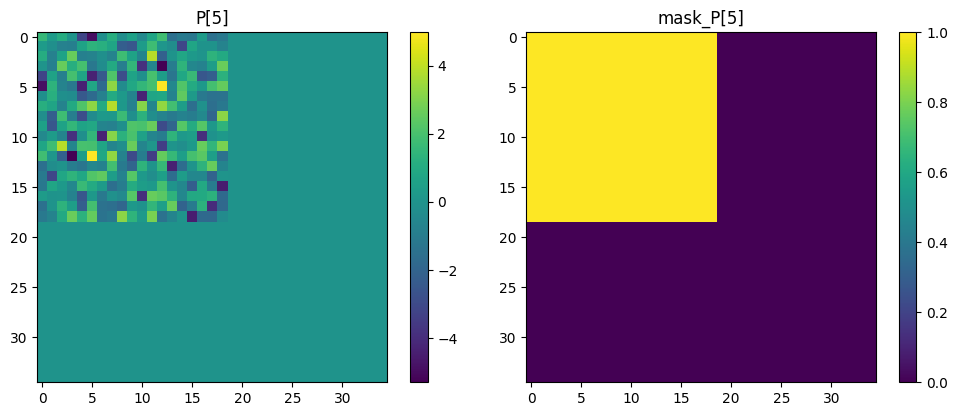

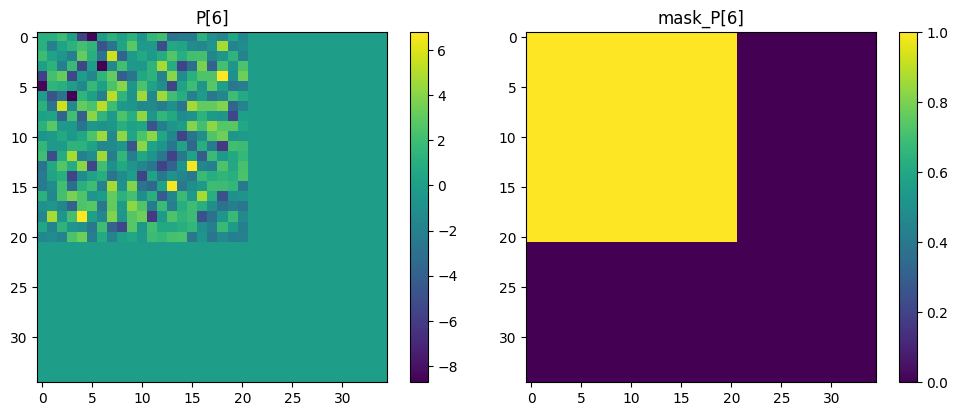

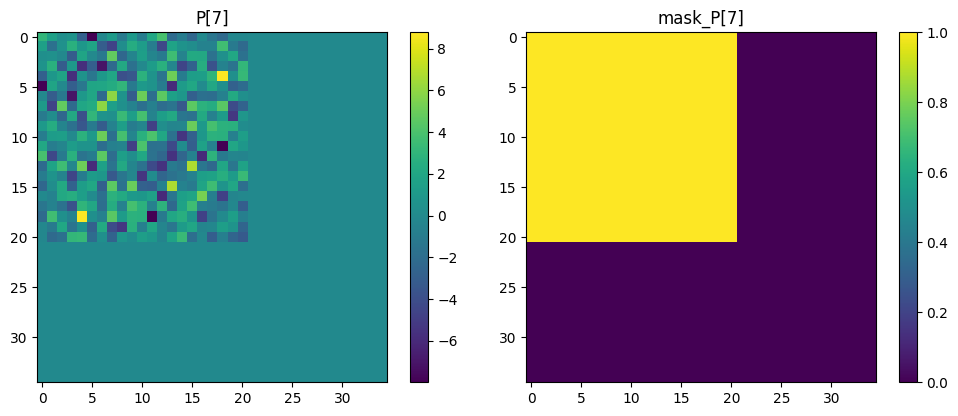

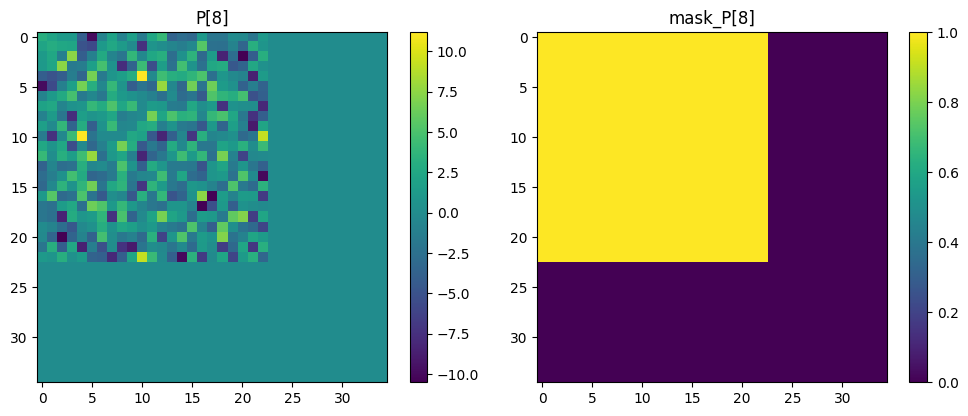

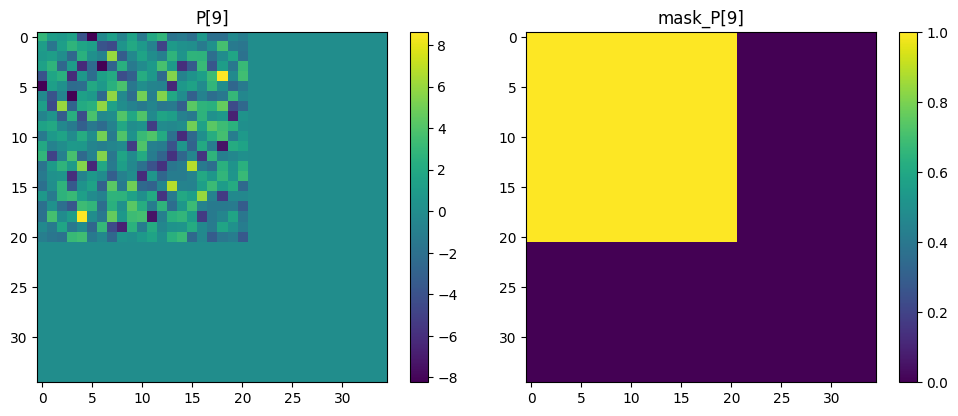

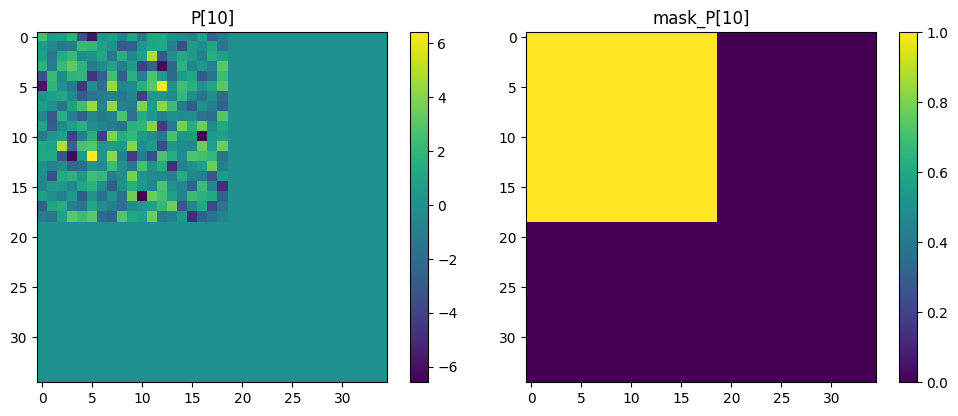

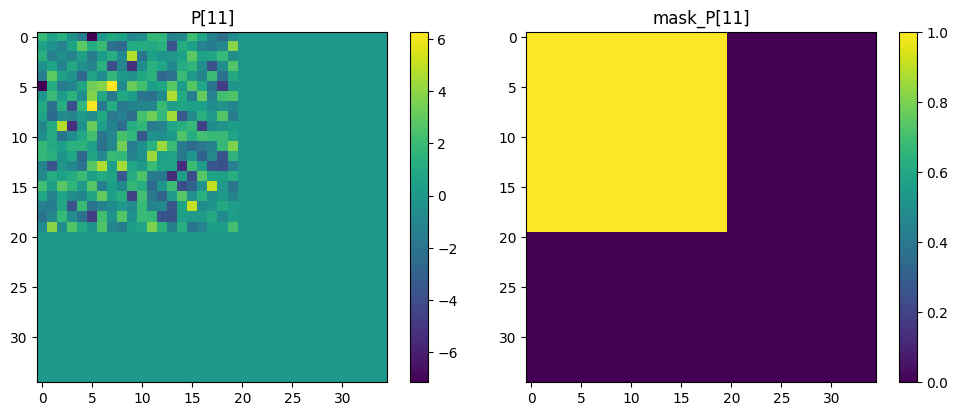

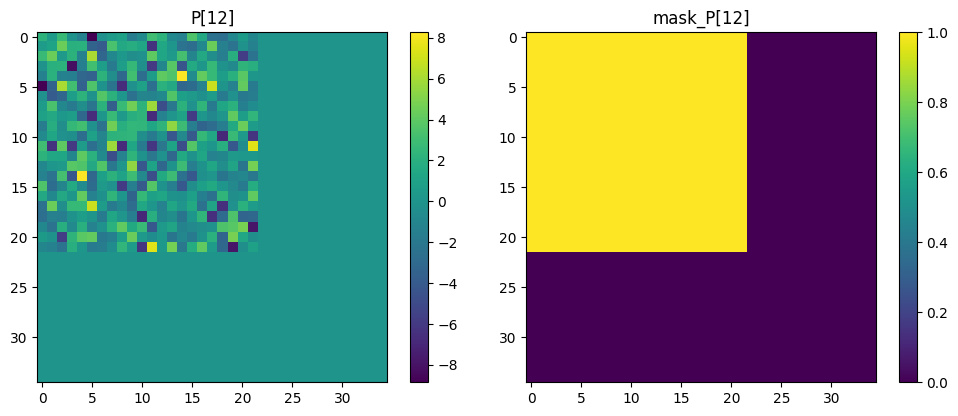

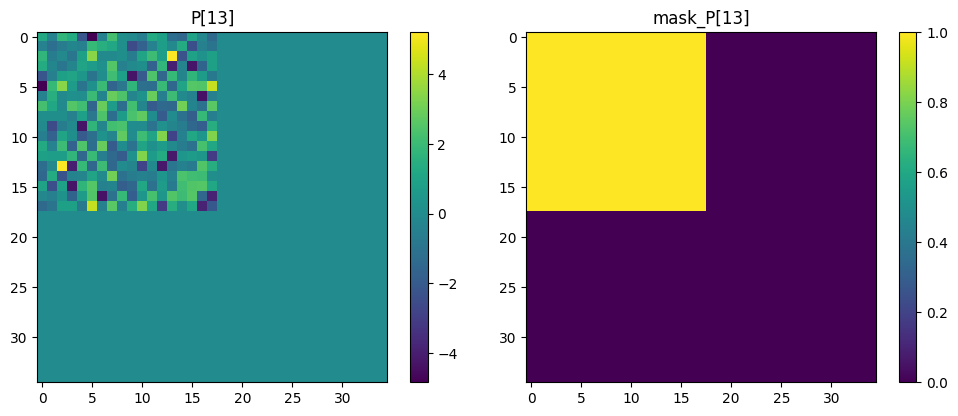

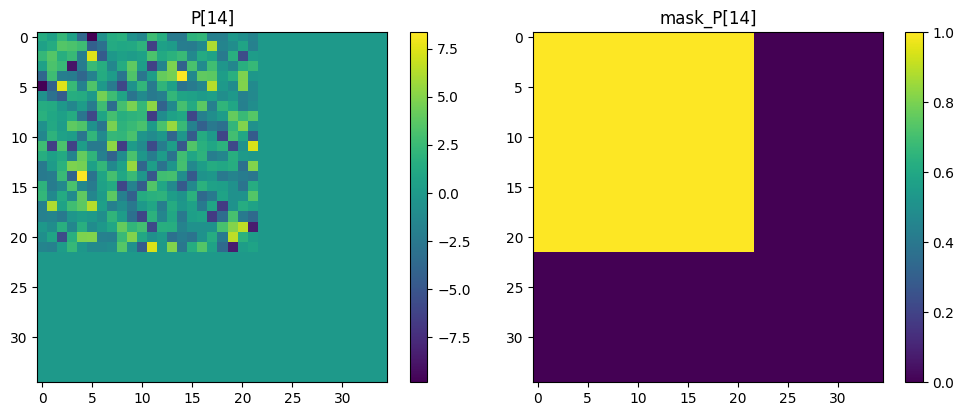

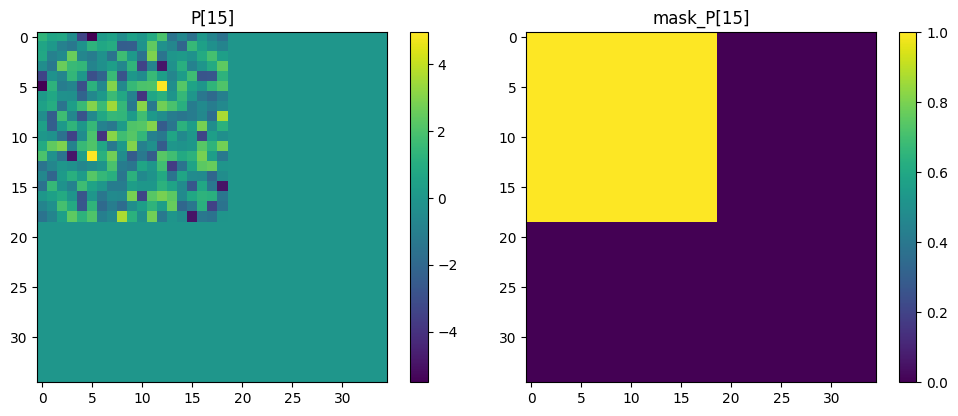

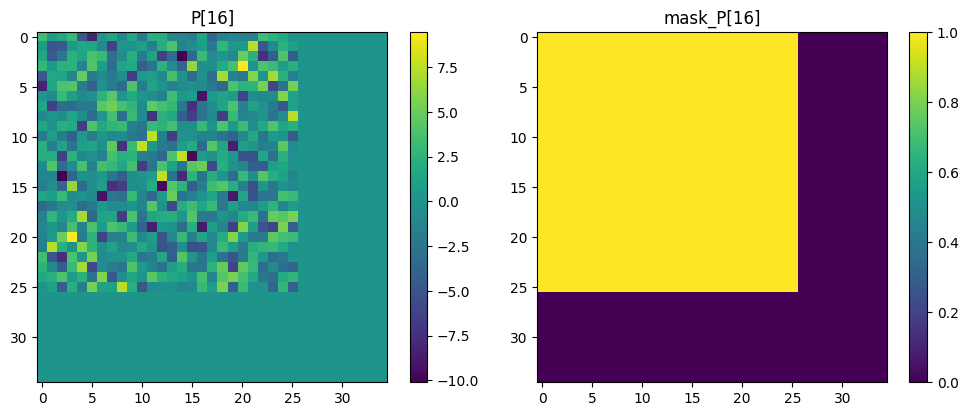

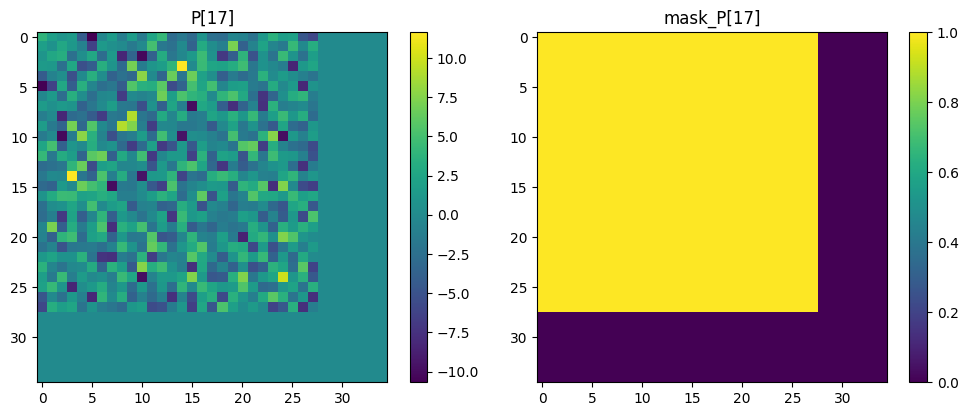

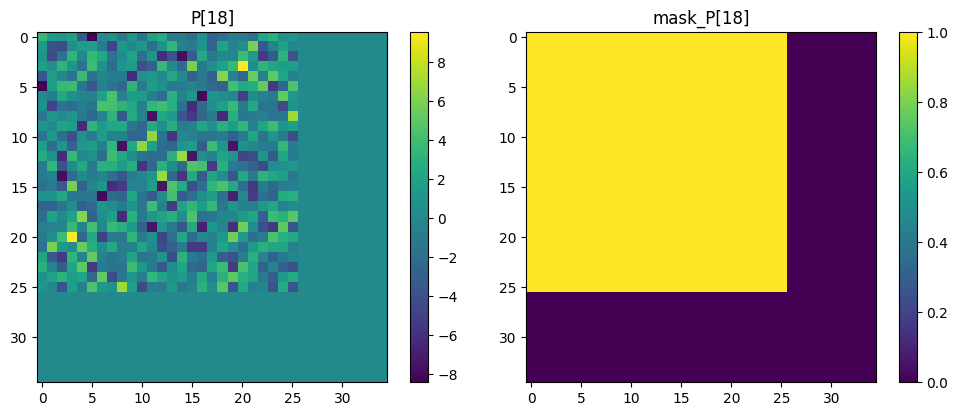

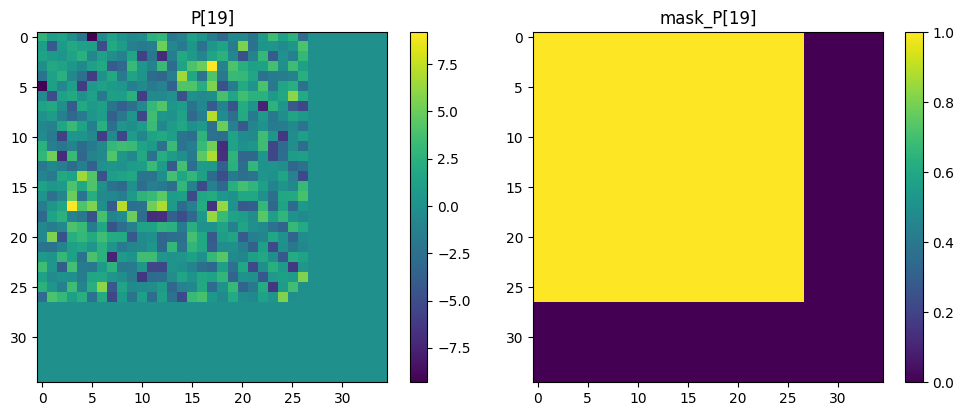

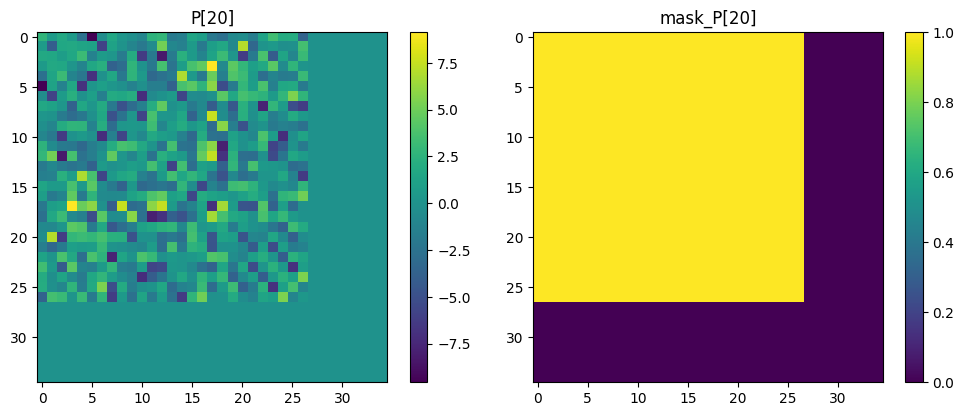

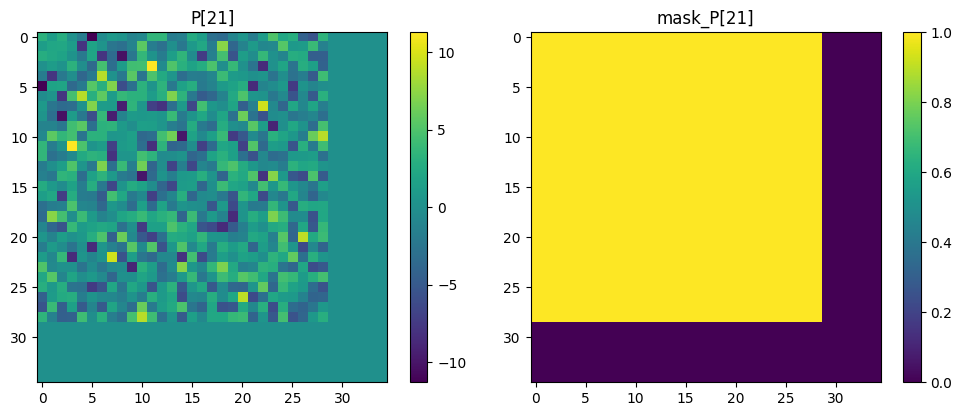

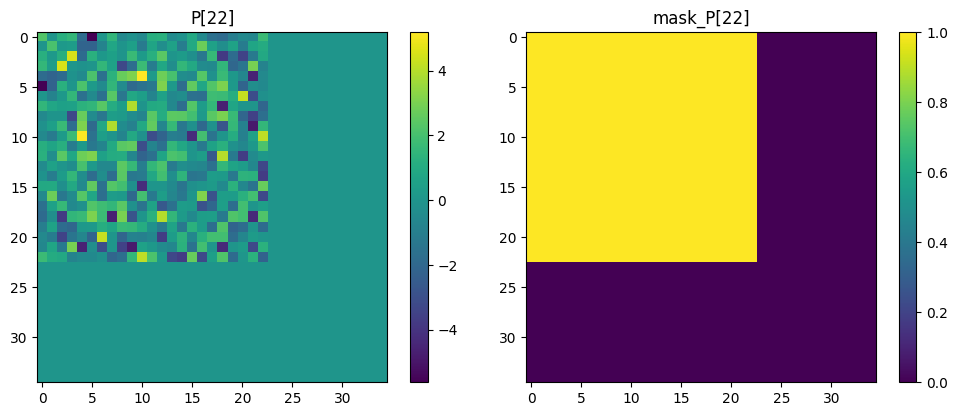

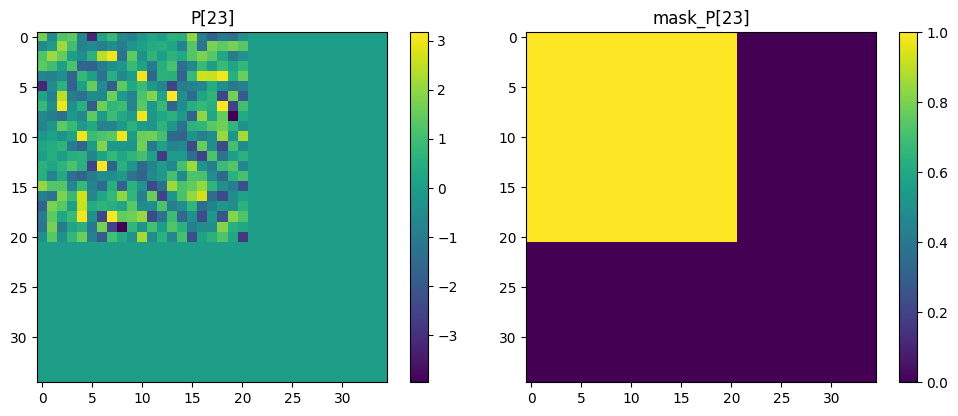

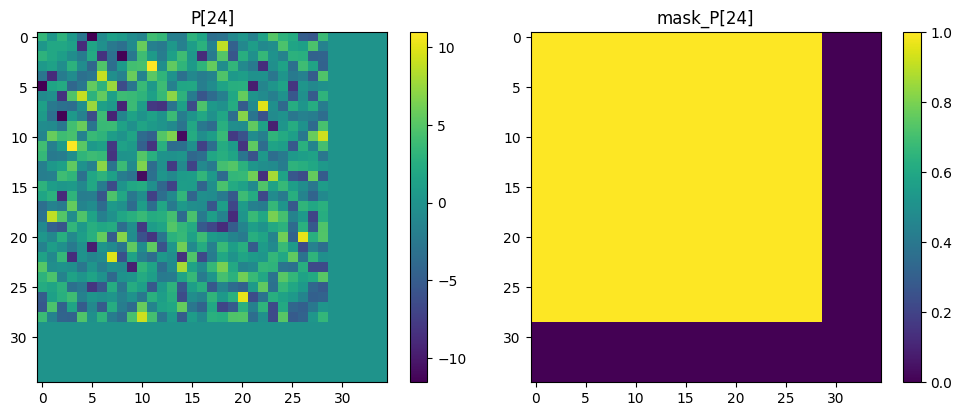

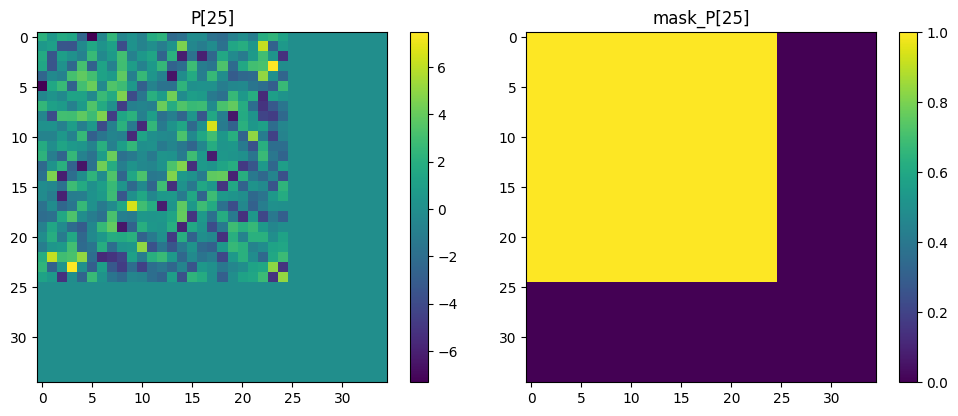

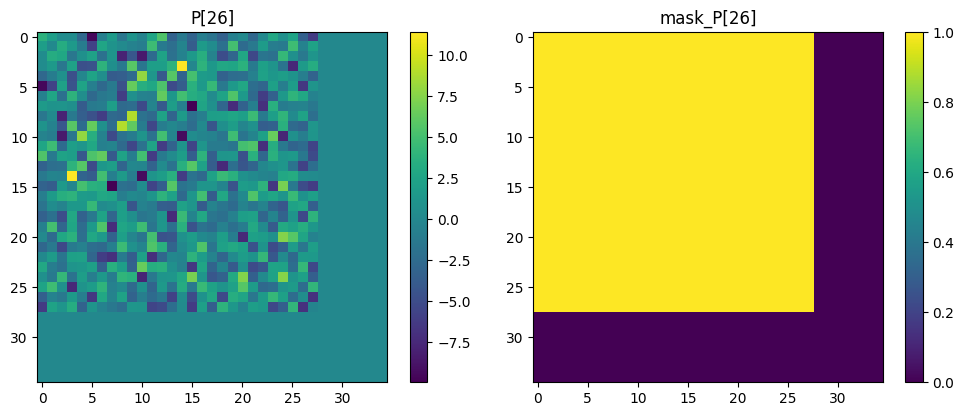

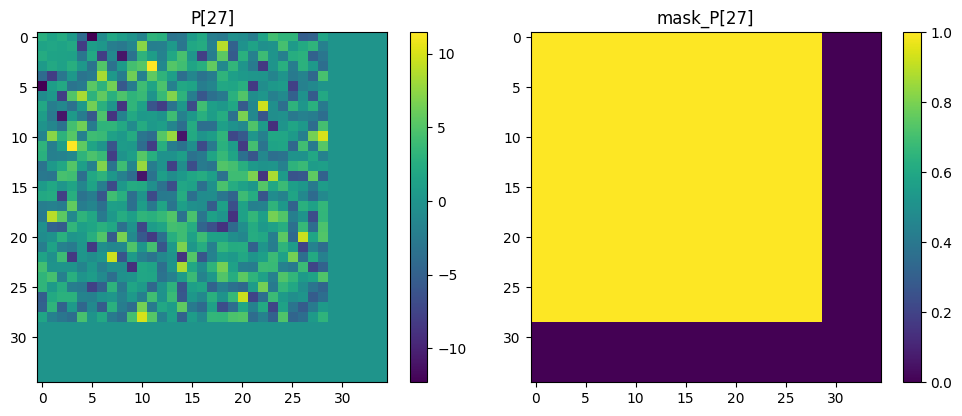

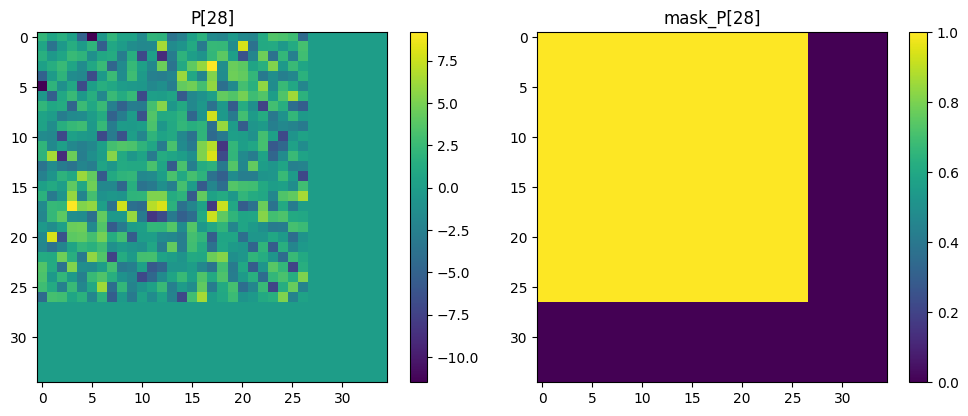

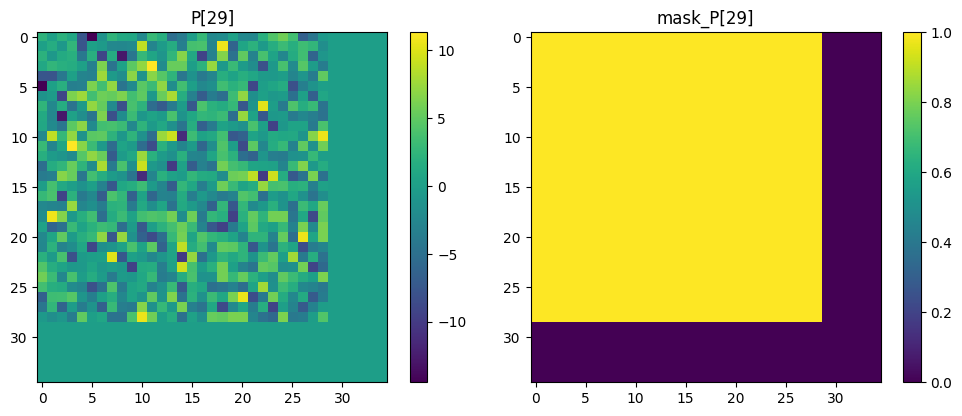

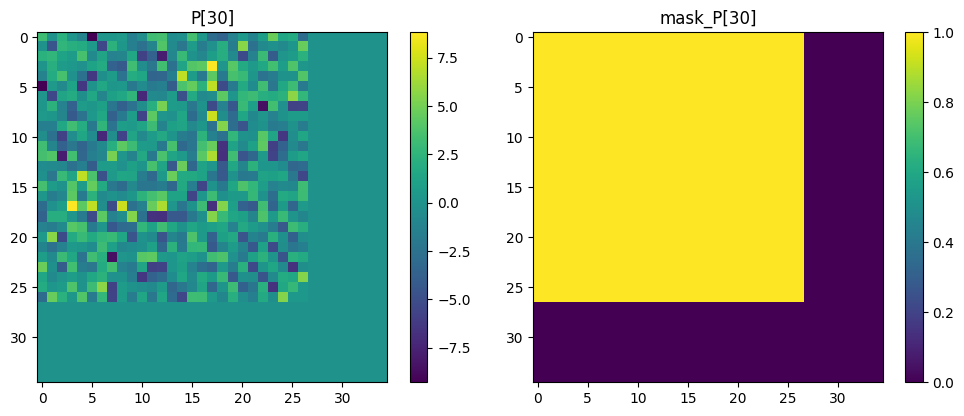

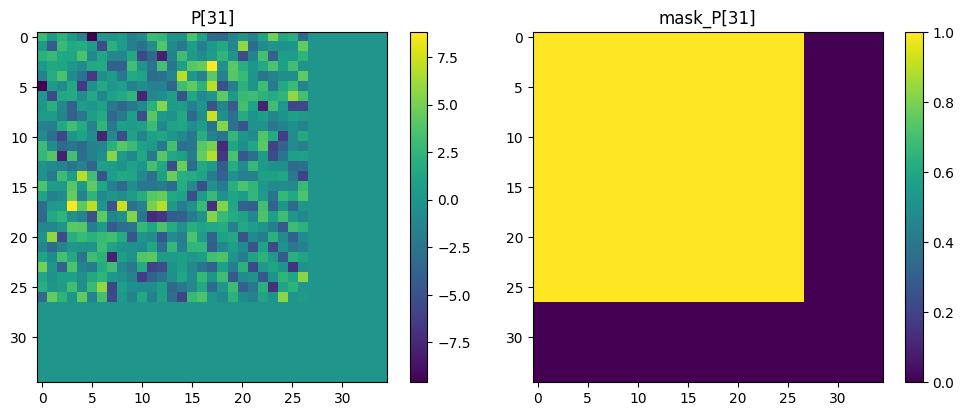

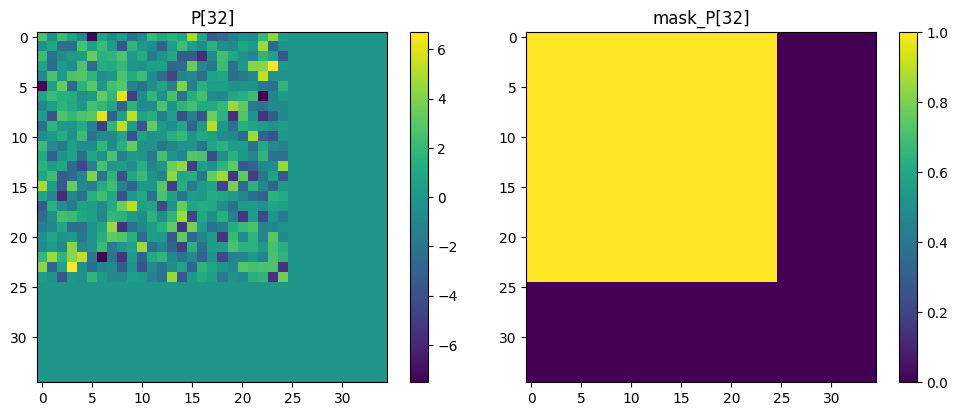

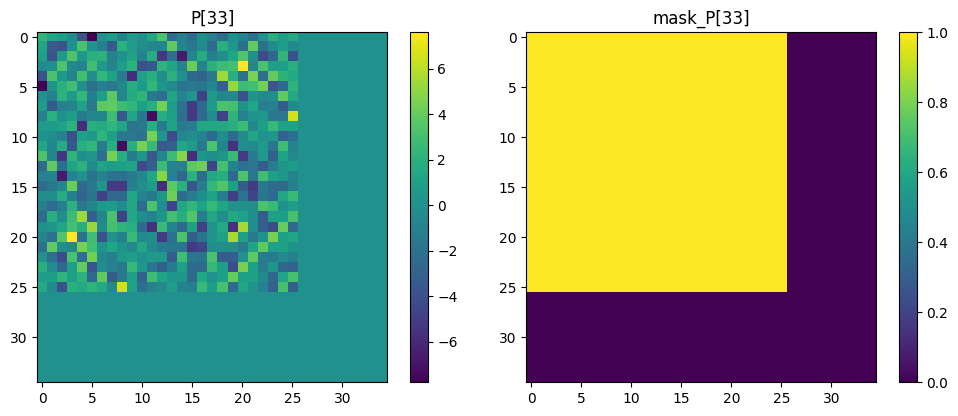

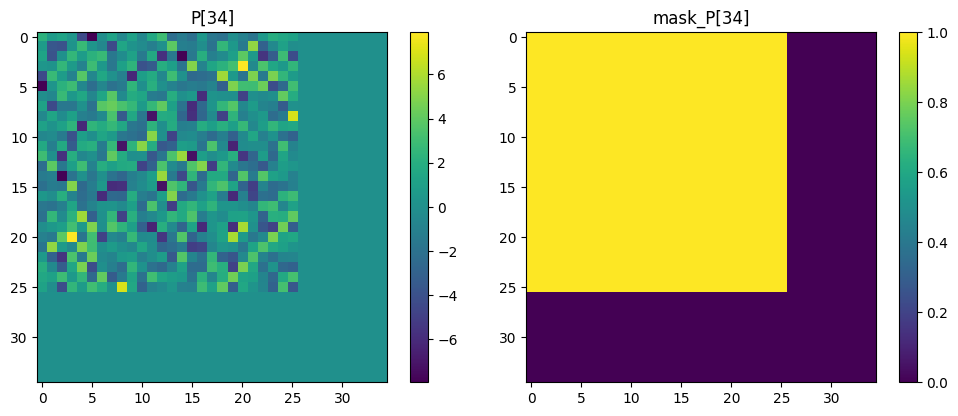

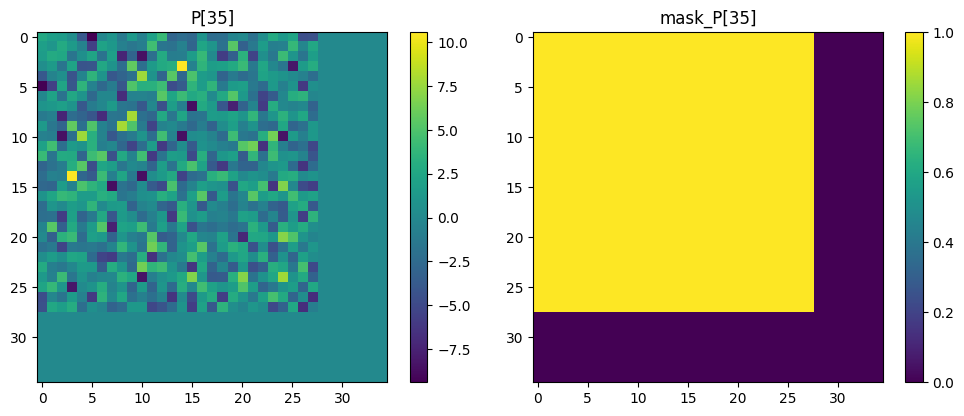

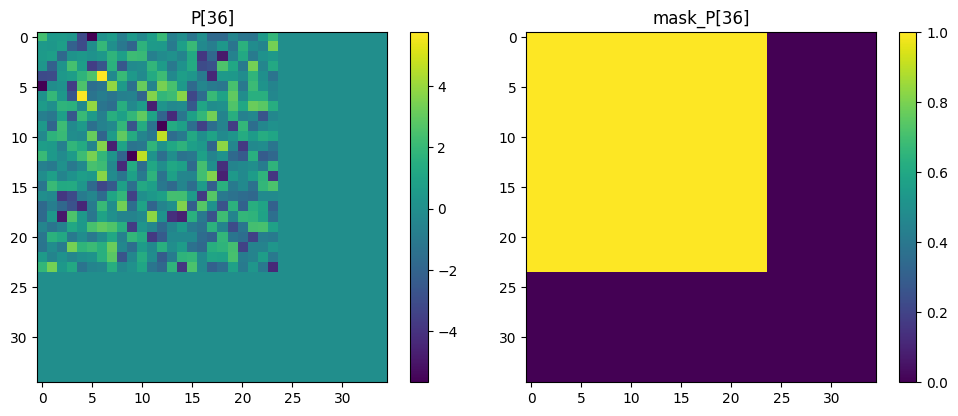

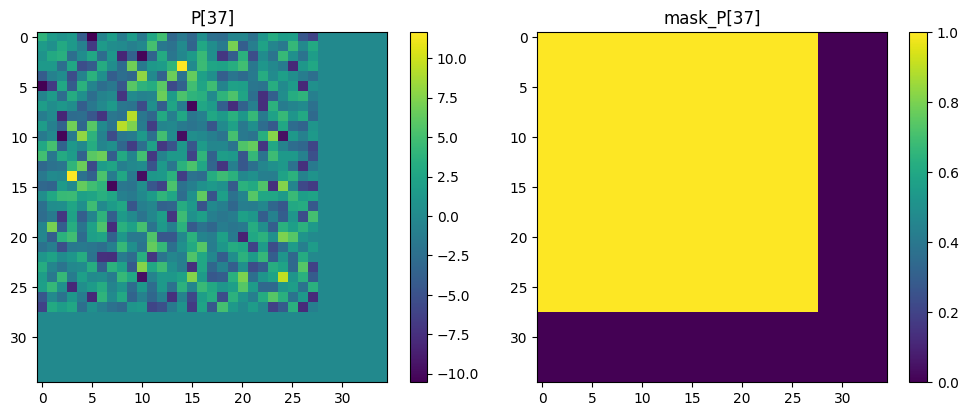

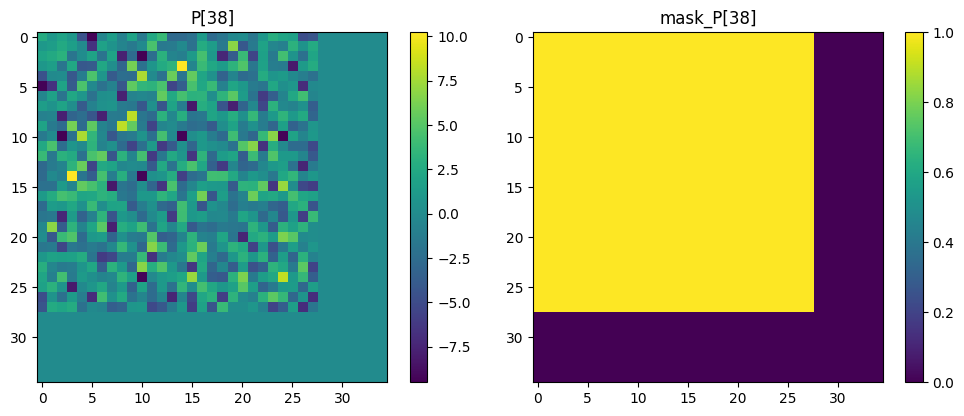

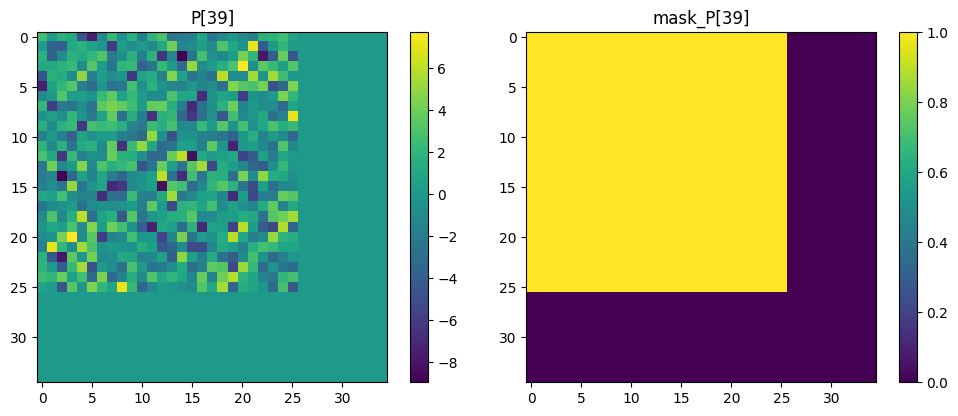

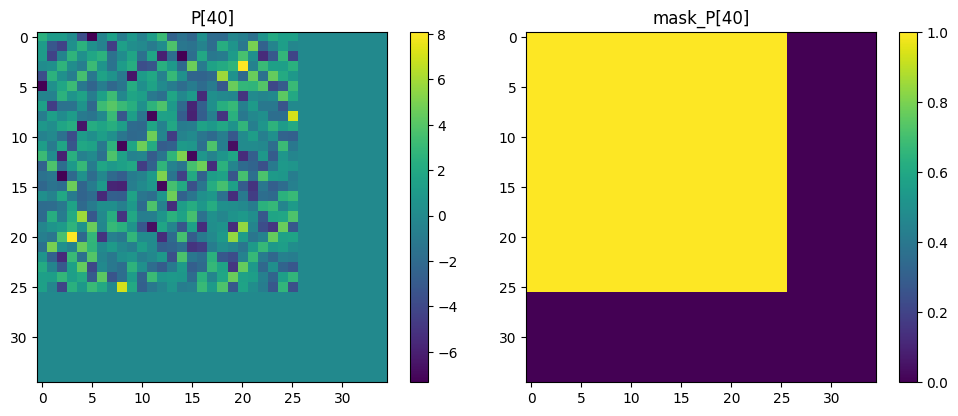

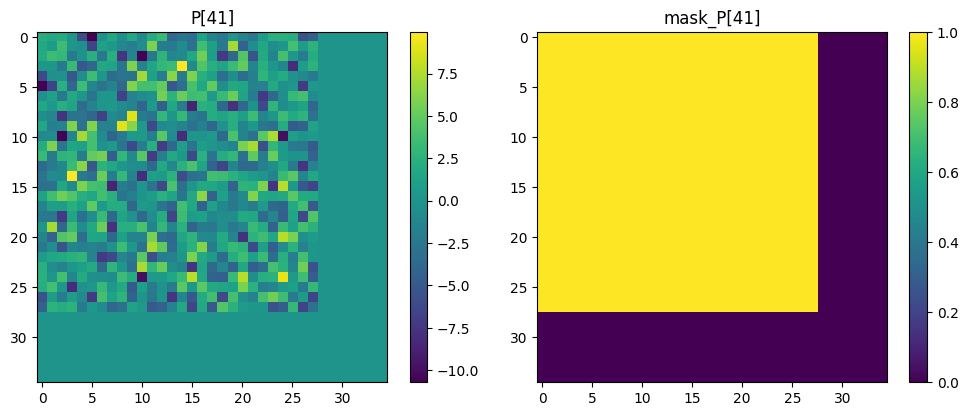

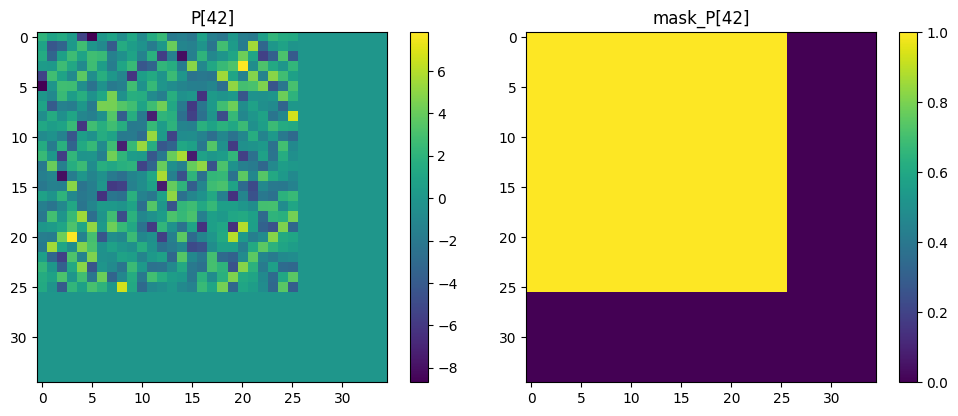

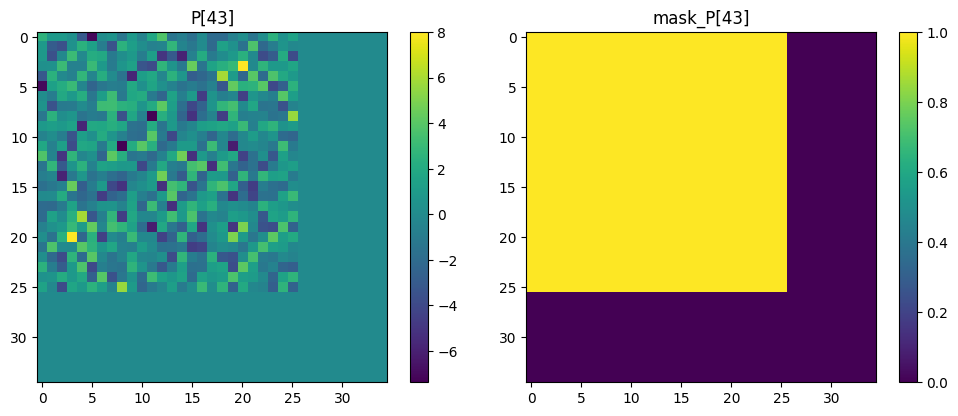

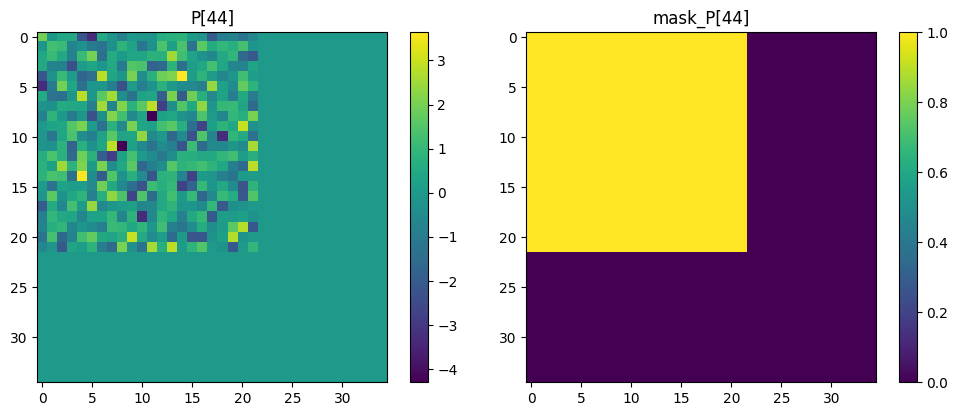

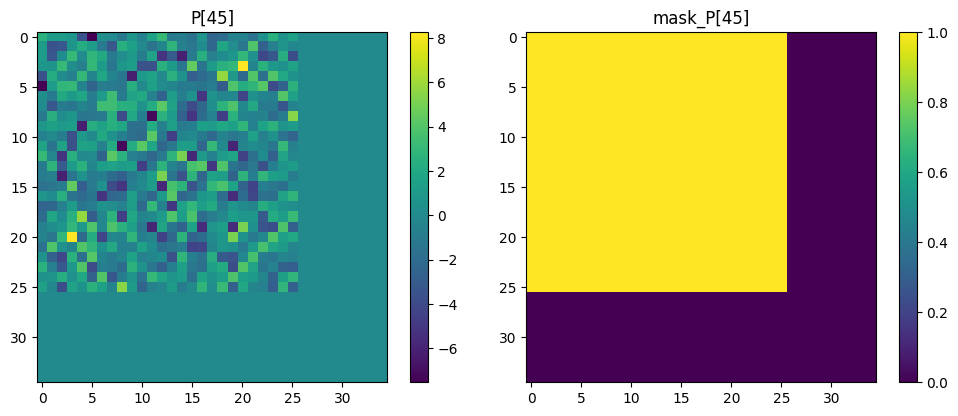

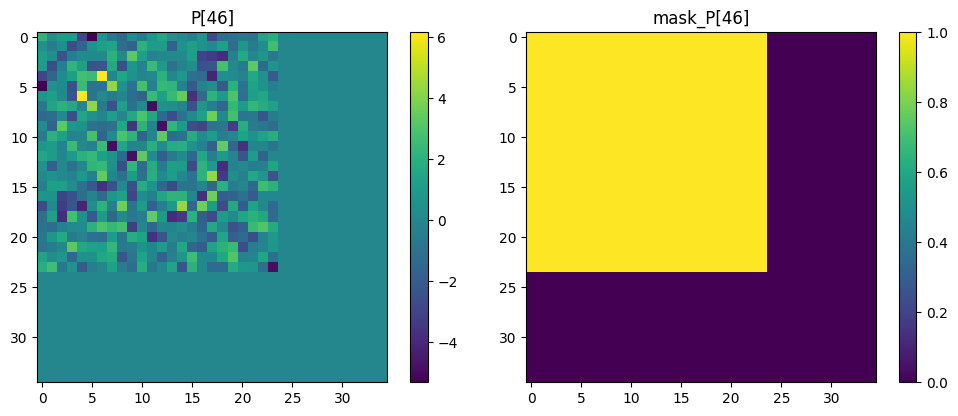

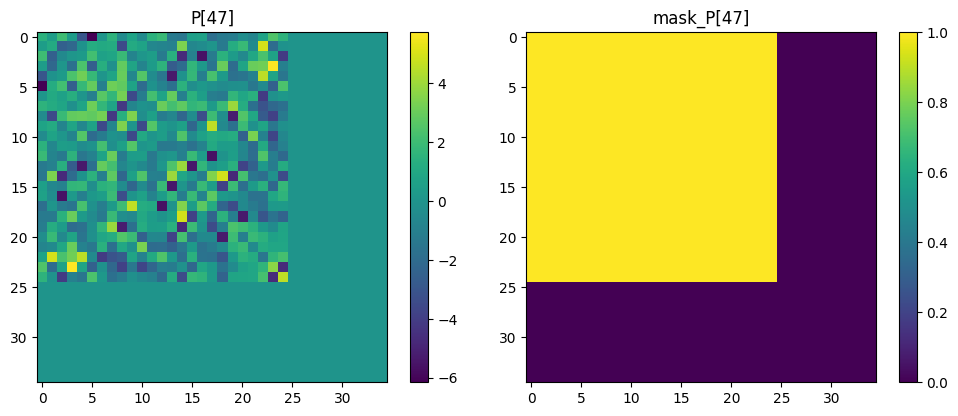

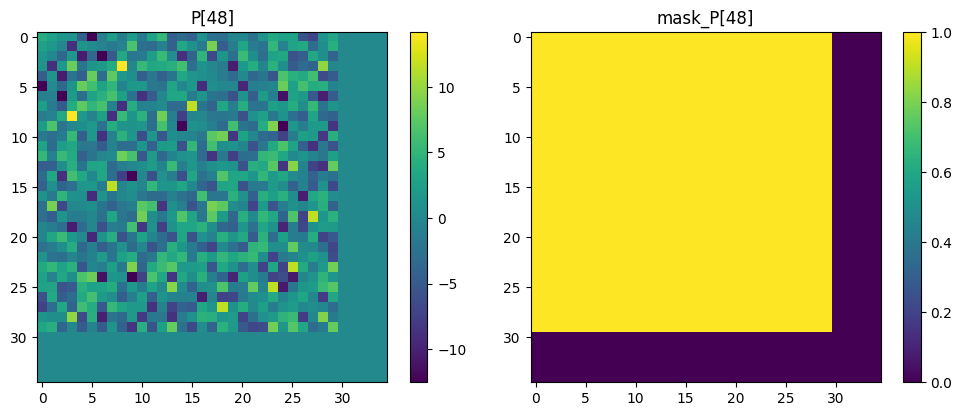

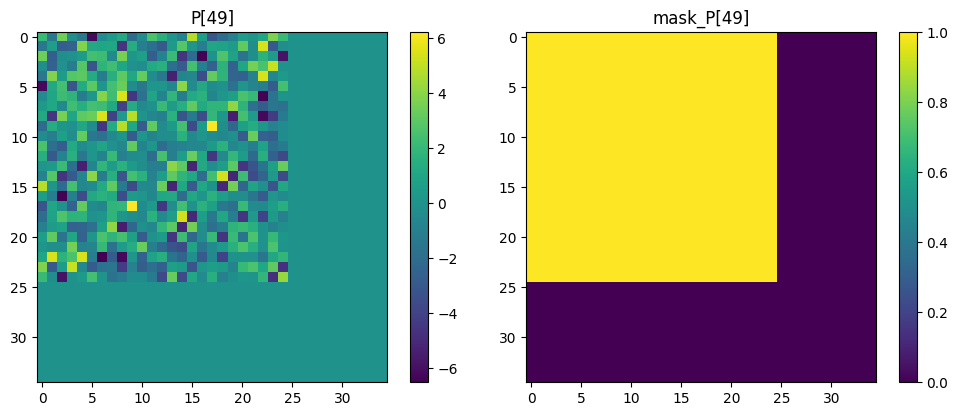

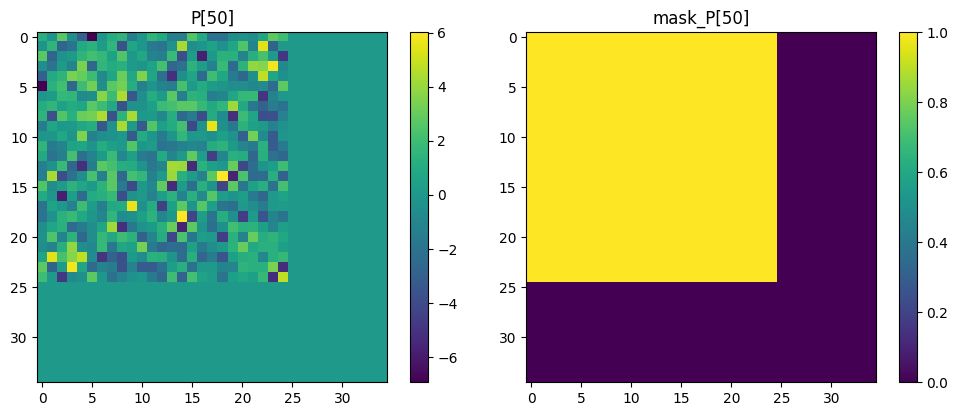

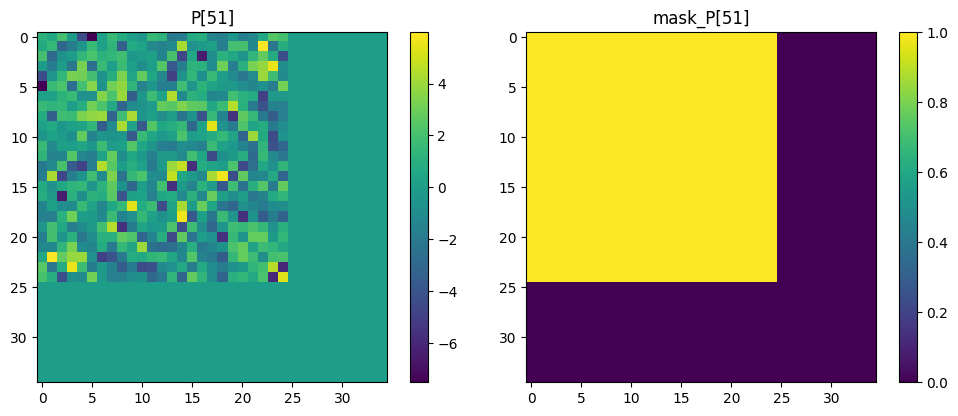

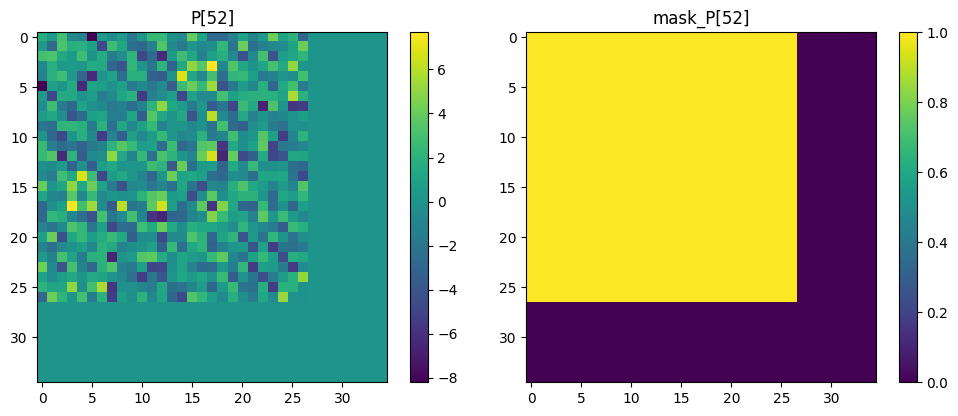

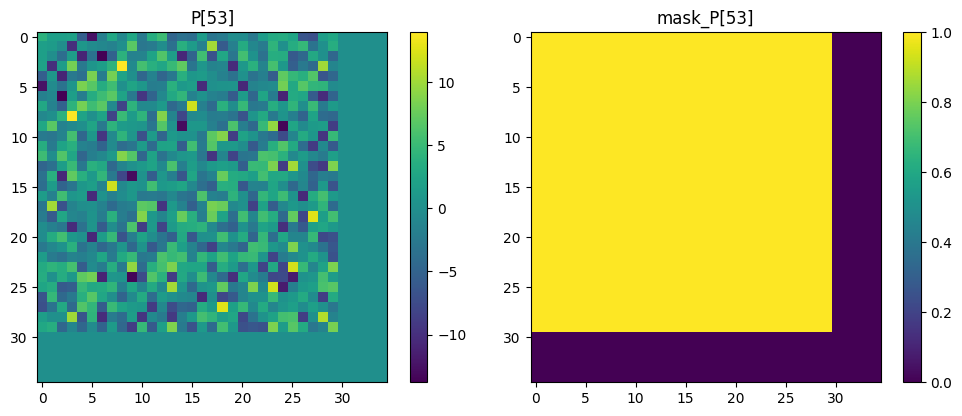

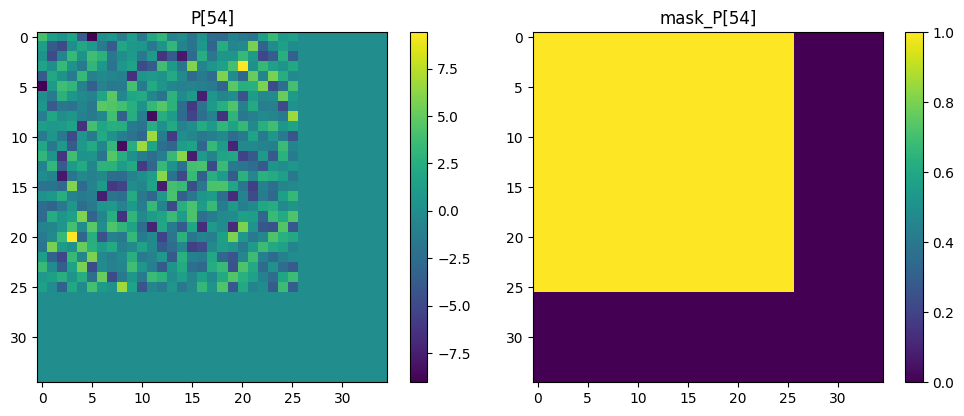

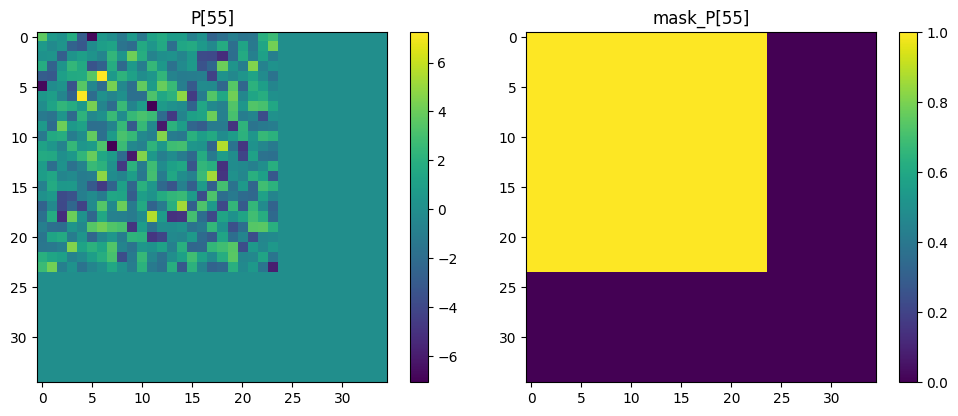

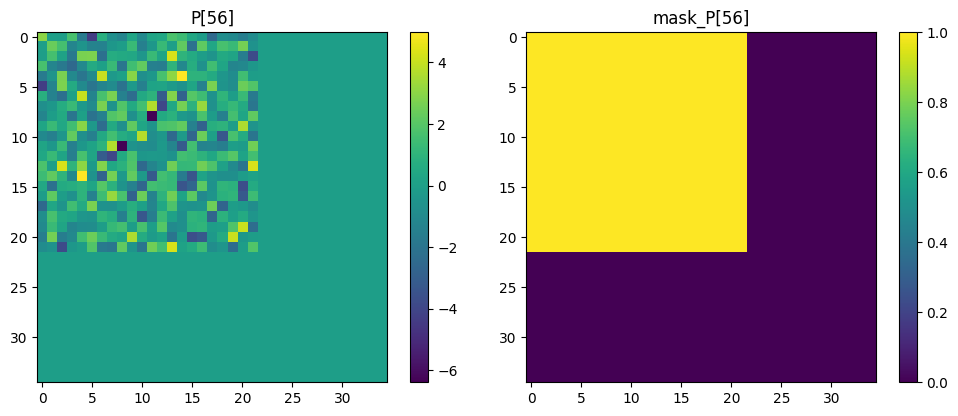

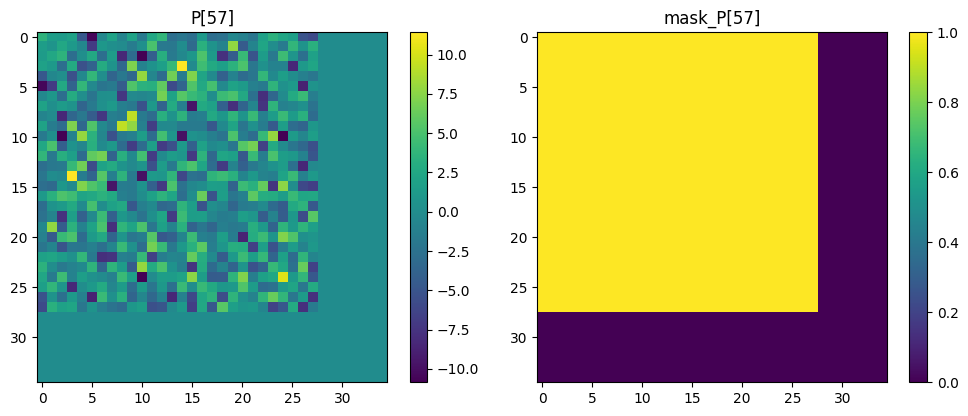

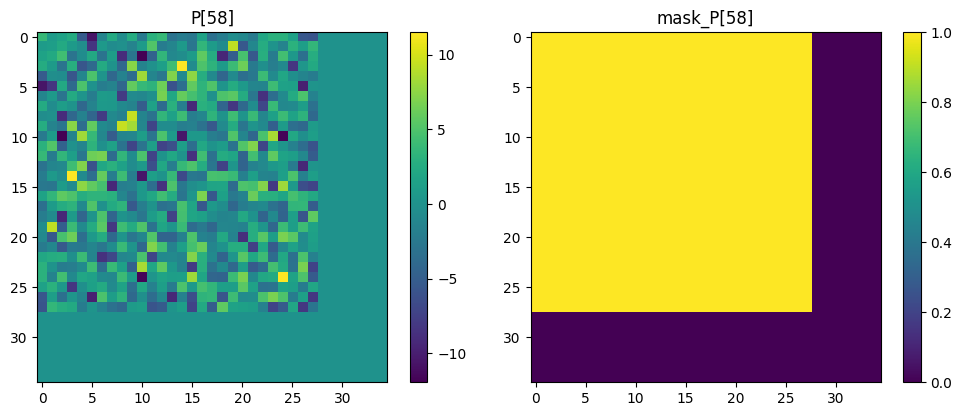

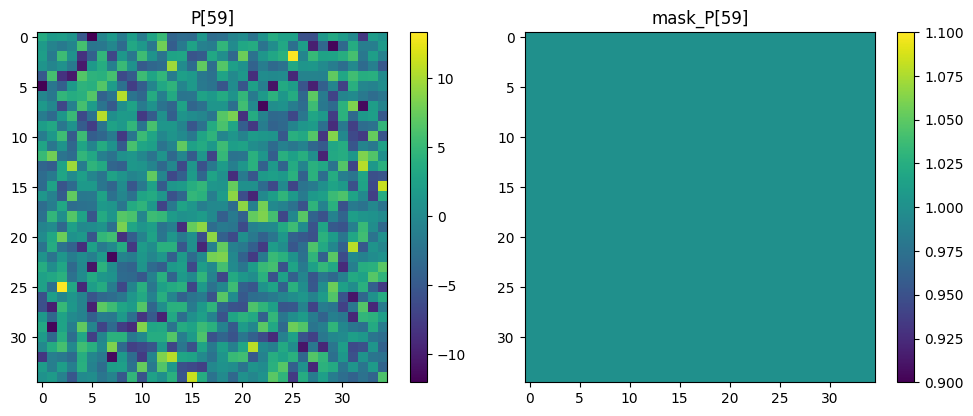

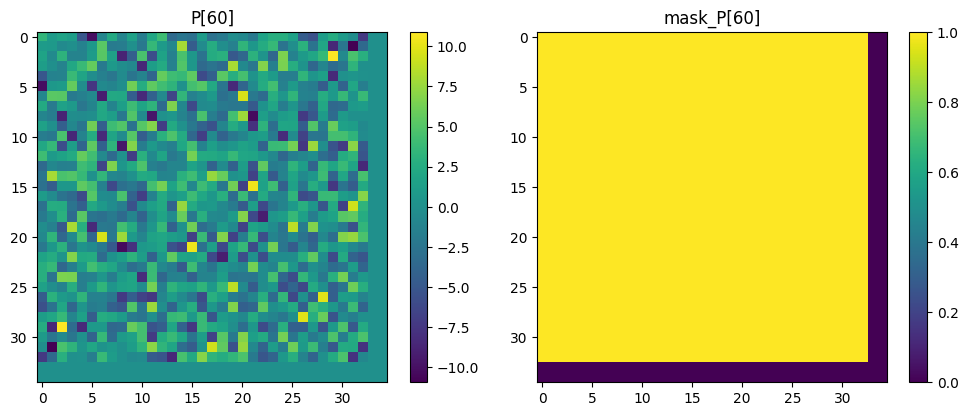

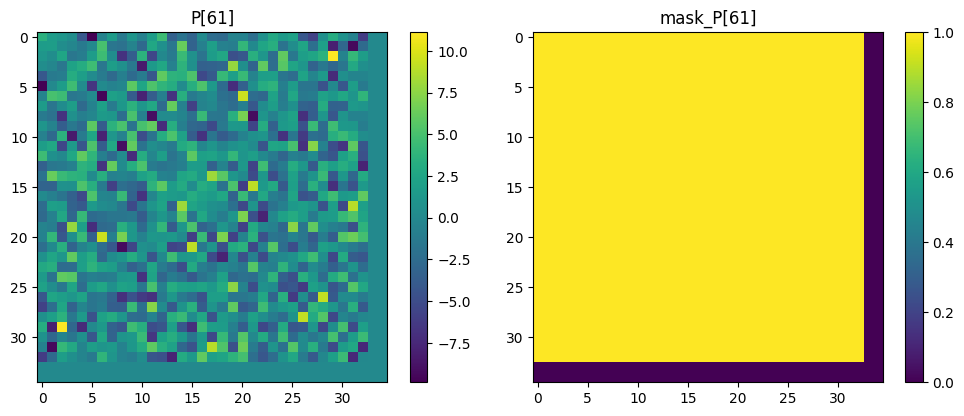

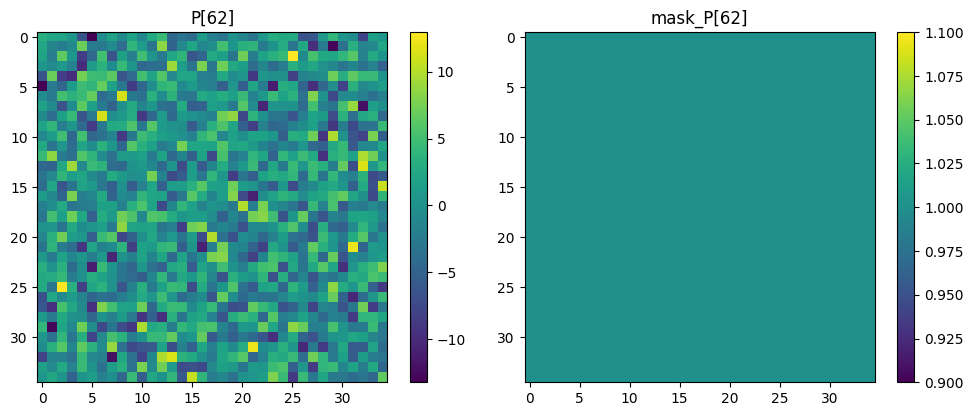

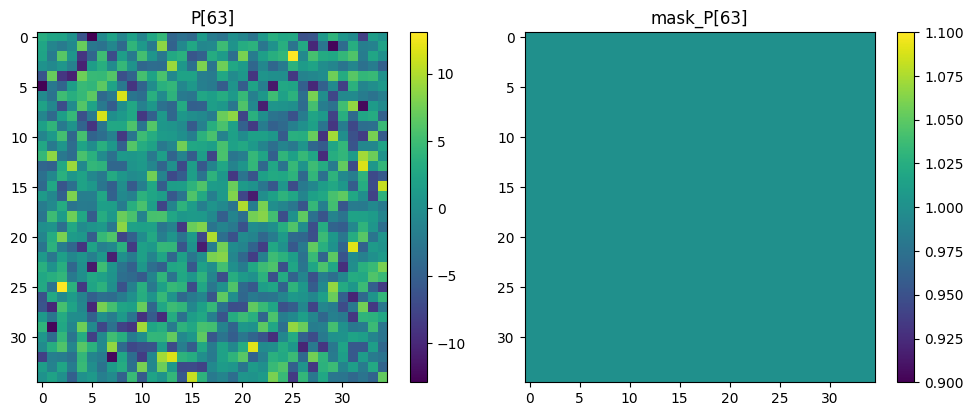

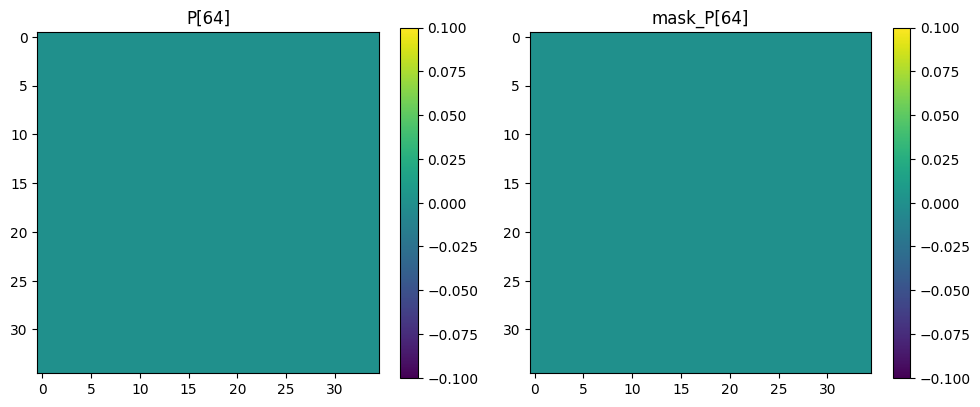

In [28]:
import matplotlib.pyplot as plt

for i in range(len(P)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axs[0].imshow(P[i])
    axs[0].set_title(f"P[{i}]")
    plt.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(mask_P[i])
    axs[1].set_title(f"mask_P[{i}]")
    plt.colorbar(im1, ax=axs[1])
    plt.tight_layout()
    plt.show()
